$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/nevoagmon/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/nevoagmon/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/nevoagmon/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


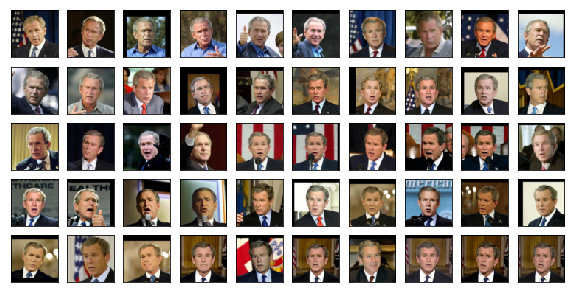

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients.

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

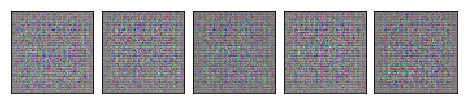

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [27]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.4, 0.999)}}


--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.89it/s]
Discriminator loss: 0.9814671944169437
Generator loss:     0.9675085684832405


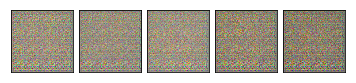

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Discriminator loss: 0.7527781795052921
Generator loss:     0.9740142331403845


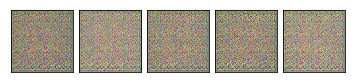

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.34it/s]
Discriminator loss: 0.6737199828905218
Generator loss:     0.9766023684950436


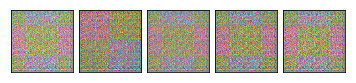

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Discriminator loss: 0.6652806506437414
Generator loss:     0.979238345342524


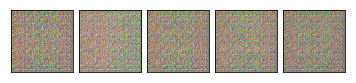

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.45it/s]
Discriminator loss: 0.6399477264460396
Generator loss:     0.9816586059682509


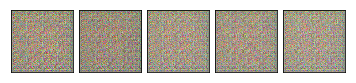

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
Discriminator loss: 0.6444095285499797
Generator loss:     0.9841013515696806


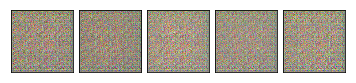

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 0.6490873869727639
Generator loss:     0.9863975924604079


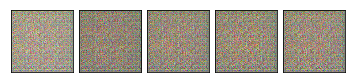

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.70it/s]
Discriminator loss: 0.6562402423690347
Generator loss:     0.9886579197995803


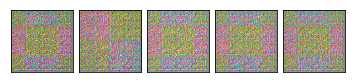

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.92it/s]
Discriminator loss: 0.6882697168518516
Generator loss:     0.9909539888886845


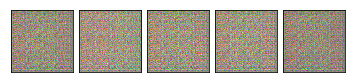

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.75it/s]
Discriminator loss: 0.6750413477420807
Generator loss:     0.9931370230282054


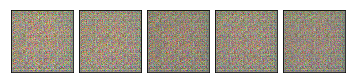

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.90it/s]
Discriminator loss: 0.6571932224666371
Generator loss:     0.995238160385805


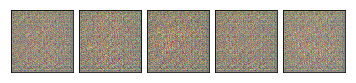

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.99it/s]
Discriminator loss: 0.6650949716567993
Generator loss:     0.9973667439292458


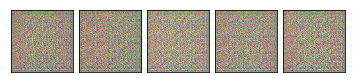

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.88it/s]
Discriminator loss: 0.6579022021854625
Generator loss:     0.9993821522768807


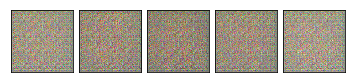

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.87it/s]
Discriminator loss: 0.6624411046504974
Generator loss:     1.0014994424932144


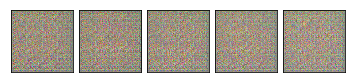

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.81it/s]
Discriminator loss: 0.6354709968847387
Generator loss:     1.0036538699093986


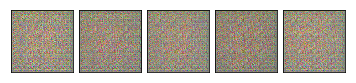

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.88it/s]
Discriminator loss: 0.6645383799777311
Generator loss:     1.0054883150493397


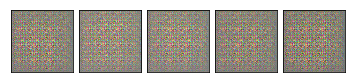

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.93it/s]
Discriminator loss: 0.6988234835512498
Generator loss:     1.0080449230530684


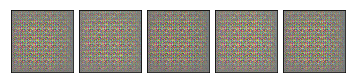

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.84it/s]
Discriminator loss: 0.6864535563132342
Generator loss:     1.009991484529832


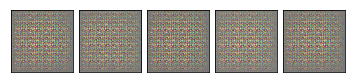

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.66it/s]
Discriminator loss: 0.6999362742199617
Generator loss:     1.0120359869564282


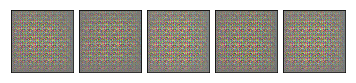

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.85it/s]
Discriminator loss: 0.6575132135082694
Generator loss:     1.0140508974299711


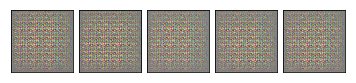

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.84it/s]
Discriminator loss: 0.5974366033778471
Generator loss:     1.016282320022583


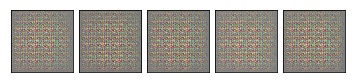

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.92it/s]
Discriminator loss: 0.6445630333002876
Generator loss:     1.0183560076881857


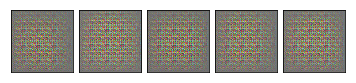

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.78it/s]
Discriminator loss: 0.6513057456297033
Generator loss:     1.0205451740938074


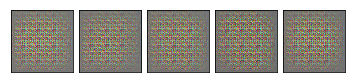

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.34it/s]
Discriminator loss: 0.5967938163701225
Generator loss:     1.7229160140542423


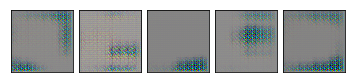

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.70it/s]
Discriminator loss: 0.5935452335021075
Generator loss:     3.3421695512883804


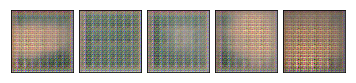

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.98it/s]
Discriminator loss: 0.7486007792108199
Generator loss:     2.665850274703082


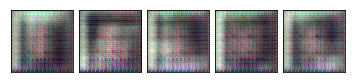

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.90it/s]
Discriminator loss: 0.6546634646023021
Generator loss:     2.897909444921157


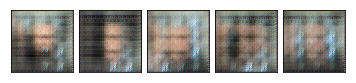

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.06it/s]
Discriminator loss: 1.1044005330871134
Generator loss:     2.4032053246217617


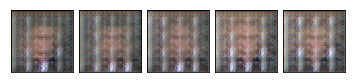

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.88it/s]
Discriminator loss: 0.8042433787794674
Generator loss:     1.1930835913209354


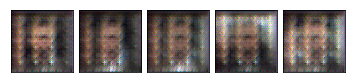

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.93it/s]
Discriminator loss: 0.7635288483956281
Generator loss:     2.565117225927465


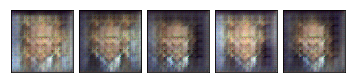

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.81it/s]
Discriminator loss: 0.8229251416290507
Generator loss:     2.583689773783964


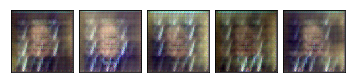

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.60it/s]
Discriminator loss: 0.71577330196605
Generator loss:     2.8597978283377254


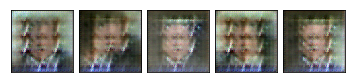

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.55it/s]
Discriminator loss: 0.9015332740895888
Generator loss:     2.3329965156667374


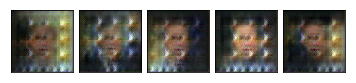

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.34it/s]
Discriminator loss: 0.6237243904786951
Generator loss:     2.770899961976444


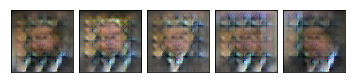

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.58it/s]
Discriminator loss: 0.6671495367498959
Generator loss:     2.710027344086591


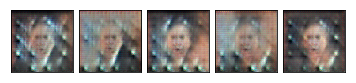

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.72it/s]
Discriminator loss: 0.7992692344328937
Generator loss:     2.6121450031504914


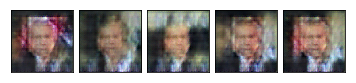

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.95it/s]
Discriminator loss: 0.6347623362260706
Generator loss:     2.792125197017894


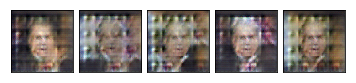

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.78it/s]
Discriminator loss: 0.6790806598523084
Generator loss:     2.9063291760051952


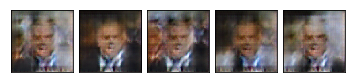

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.85it/s]
Discriminator loss: 0.6203314854818232
Generator loss:     2.635581710759331


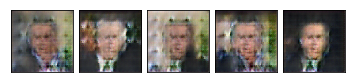

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.73it/s]
Discriminator loss: 0.7085841718842002
Generator loss:     2.7277000932132496


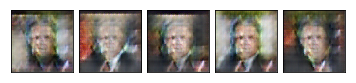

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.91it/s]
Discriminator loss: 0.7596726627910838
Generator loss:     2.7132781603757072


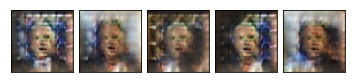

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.88it/s]
Discriminator loss: 0.6857665128567639
Generator loss:     2.7902831891003776


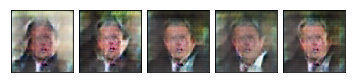

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.69it/s]
Discriminator loss: 0.7141097924288582
Generator loss:     2.8352832443573894


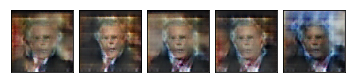

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.50it/s]
Discriminator loss: 0.6967305505976957
Generator loss:     2.4784221719293034


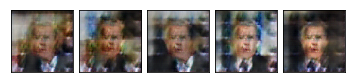

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.80it/s]
Discriminator loss: 0.6974977324990665
Generator loss:     2.6882637248319736


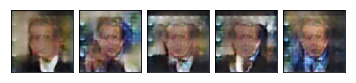

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.96it/s]
Discriminator loss: 0.701961594469407
Generator loss:     2.6552779394037582


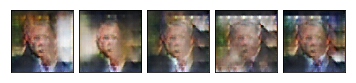

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.00it/s]
Discriminator loss: 0.6898896343567792
Generator loss:     2.5644138981314266


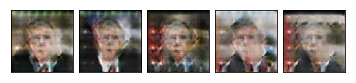

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.92it/s]
Discriminator loss: 0.7138582187540391
Generator loss:     2.915371537208557


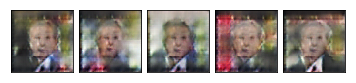

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.66it/s]
Discriminator loss: 0.5752047598361969
Generator loss:     2.8139693596783806


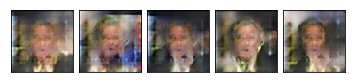

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.42it/s]
Discriminator loss: 0.6298704129808089
Generator loss:     2.8997112582711613


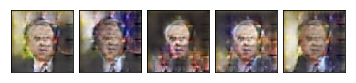

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.48it/s]
Discriminator loss: 0.6441518997444826
Generator loss:     2.945786237716675


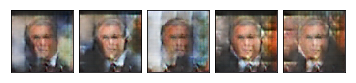

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.54it/s]
Discriminator loss: 0.6408993812168345
Generator loss:     2.9934714401469513


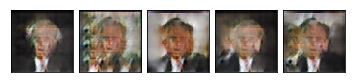

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.89it/s]
Discriminator loss: 0.5212773996240953
Generator loss:     3.0021650440552654


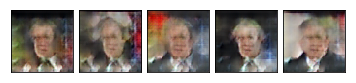

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.84it/s]
Discriminator loss: 0.4552205310148351
Generator loss:     3.12171532126034


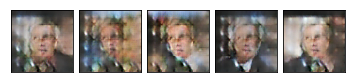

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.88it/s]
Discriminator loss: 0.7173734465066124
Generator loss:     2.753553173121284


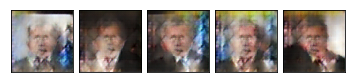

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.02it/s]
Discriminator loss: 0.6821672653450686
Generator loss:     2.6487772464752197


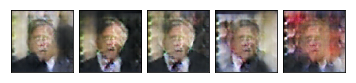

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.57it/s]
Discriminator loss: 0.6195611743366017
Generator loss:     2.6461311298258163


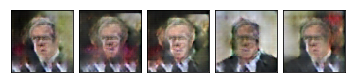

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.79it/s]
Discriminator loss: 0.5663347875370699
Generator loss:     2.8817873982822193


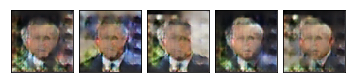

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.54it/s]
Discriminator loss: 0.5598657762303072
Generator loss:     2.8938650804407455


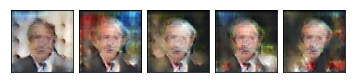

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.89it/s]
Discriminator loss: 0.6101464997319614
Generator loss:     2.9301597230574665


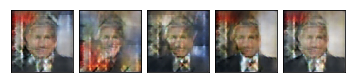

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.52it/s]
Discriminator loss: 0.5622673455406638
Generator loss:     2.9185768716475544


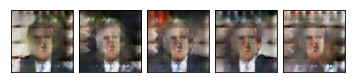

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.72it/s]
Discriminator loss: 0.4580763823845807
Generator loss:     3.1992811174953686


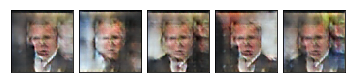

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.35it/s]
Discriminator loss: 0.5226891005740446
Generator loss:     3.0549845204633823


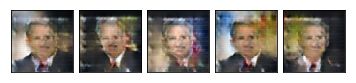

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.91it/s]
Discriminator loss: 0.7040571570396423
Generator loss:     2.9273415242924408


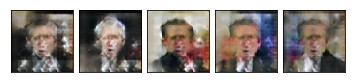

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.08it/s]
Discriminator loss: 0.7745738415157094
Generator loss:     2.9175285661921784


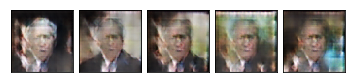

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.13it/s]
Discriminator loss: 0.6179401962196126
Generator loss:     2.737586961073034


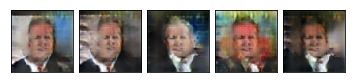

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.27it/s]
Discriminator loss: 0.5828834105940426
Generator loss:     2.778610159369076


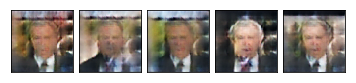

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.11it/s]
Discriminator loss: 0.4848417008624357
Generator loss:     2.982105521594777


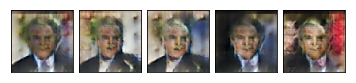

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.10it/s]
Discriminator loss: 0.5431452638962689
Generator loss:     3.0528880568111645


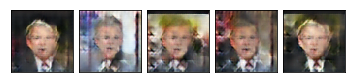

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.12it/s]
Discriminator loss: 0.39195066427483277
Generator loss:     3.11392001544728


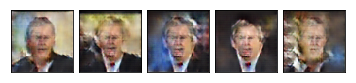

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.01it/s]
Discriminator loss: 0.5754311593139873
Generator loss:     3.2095008737900677


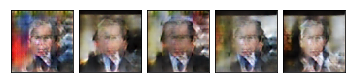

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.593082960914163
Generator loss:     2.966674797675189


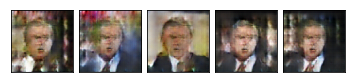

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.03it/s]
Discriminator loss: 0.5719747560865739
Generator loss:     2.9190882514504826


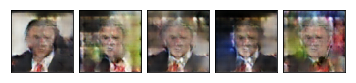

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.08it/s]
Discriminator loss: 0.5437079054467818
Generator loss:     3.055091472233043


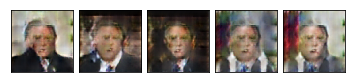

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.10it/s]
Discriminator loss: 0.5536390069653007
Generator loss:     2.854794340975144


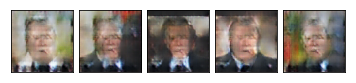

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.98it/s]
Discriminator loss: 0.5544414520263672
Generator loss:     3.27891206741333


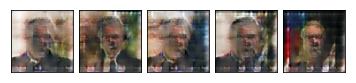

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.04it/s]
Discriminator loss: 0.457275250378777
Generator loss:     3.1435070037841797


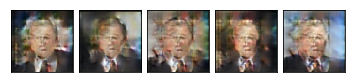

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.76it/s]
Discriminator loss: 0.5444165748708388
Generator loss:     3.1108302228591023


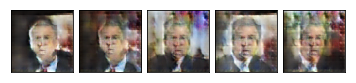

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.53it/s]
Discriminator loss: 0.540039227289312
Generator loss:     3.017135080169229


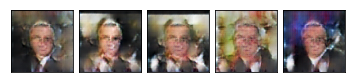

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.36it/s]
Discriminator loss: 0.6018907936180339
Generator loss:     3.1321643520804012


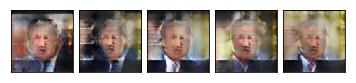

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.72it/s]
Discriminator loss: 0.4836786108858445
Generator loss:     3.1230122201582966


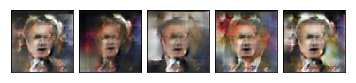

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.80it/s]
Discriminator loss: 0.44655266754767475
Generator loss:     3.2368342175203213


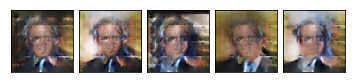

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.87it/s]
Discriminator loss: 0.4742170510923161
Generator loss:     3.2177103407242718


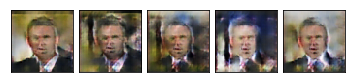

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.91it/s]
Discriminator loss: 0.4401464935611276
Generator loss:     3.470089042887968


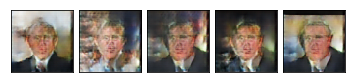

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.90it/s]
Discriminator loss: 0.5580368410138523
Generator loss:     3.5618496081408333


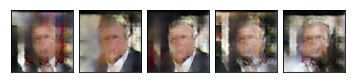

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.73it/s]
Discriminator loss: 0.4958179102224462
Generator loss:     3.216046964420992


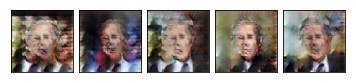

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.89it/s]
Discriminator loss: 0.473136049859664
Generator loss:     3.132875540677239


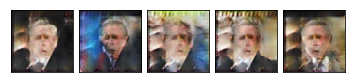

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.68it/s]
Discriminator loss: 0.5407893438549602
Generator loss:     3.3796400042141186


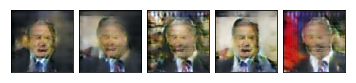

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.66it/s]
Discriminator loss: 0.43292916522306557
Generator loss:     3.260058080448824


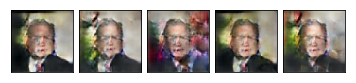

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.34it/s]
Discriminator loss: 0.5141965992310468
Generator loss:     2.9889750059913185


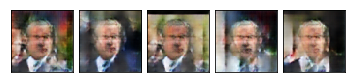

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.51it/s]
Discriminator loss: 0.6376055110903347
Generator loss:     3.366649445365457


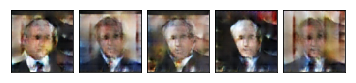

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.80it/s]
Discriminator loss: 0.5683217592099133
Generator loss:     3.2136027883080875


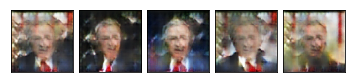

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.86it/s]
Discriminator loss: 0.4262181353919646
Generator loss:     3.2981723617104923


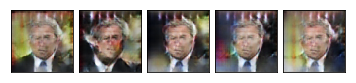

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.32it/s]
Discriminator loss: 0.5240407761405496
Generator loss:     3.2408901803633747


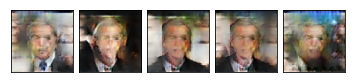

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.99it/s]
Discriminator loss: 0.44856313572210427
Generator loss:     3.019542048959171


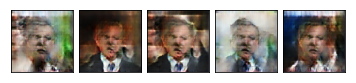

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.78it/s]
Discriminator loss: 0.554168716949575
Generator loss:     3.172862740123973


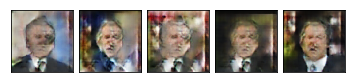

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.19it/s]
Discriminator loss: 0.5211743554648232
Generator loss:     3.1452384415794823


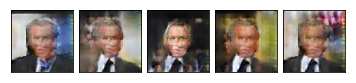

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.10it/s]
Discriminator loss: 0.42834285164580627
Generator loss:     3.2772267355638394


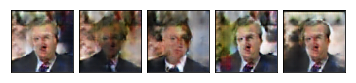

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.10it/s]
Discriminator loss: 0.3944619341808207
Generator loss:     3.4162221095141243


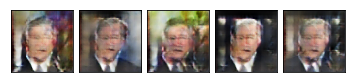

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.03it/s]
Discriminator loss: 0.4191407368463628
Generator loss:     3.446254898520077


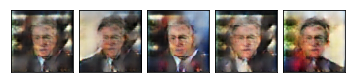

In [28]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


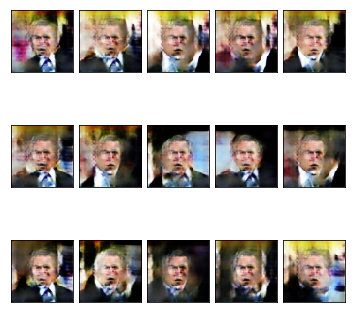

In [24]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(hw3.answers.part3_q2)

### Question 2

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(hw3.answers.part3_q3)